In [59]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

In [7]:
#leitura do arquivo xml
tree = ET.parse('./example_files/dos_csau.xml')
dos = tree.getroot()

In [146]:
#Lets see the structure of the file

for child in dos:
    print(child.tag,child.attrib)

#structure of the partialdos element
print('\n PARTIALDOS ELEMENT')
for element in dos.iter('partialdos'):
    print(element.tag,element.attrib)
    for subchild in element:
        print('\t',subchild.tag,subchild.attrib)

title {}
axis {'label': 'Energy', 'unit': 'Hartree'}
axis {'label': 'DOS', 'unit': 'states/Hartree/unit cell'}
totaldos {}
partialdos {'type': 'partial', 'speciessym': 'Au', 'speciesrn': '1', 'atom': '1'}
partialdos {'type': 'partial', 'speciessym': 'Cs', 'speciesrn': '2', 'atom': '1'}
limrep {}
interstitialdos {}

 PARTIALDOS ELEMENT
partialdos {'type': 'partial', 'speciessym': 'Au', 'speciesrn': '1', 'atom': '1'}
	 diagram {'nspin': '1', 'l': '0'}
	 diagram {'nspin': '1', 'l': '1'}
	 diagram {'nspin': '1', 'l': '2'}
	 diagram {'nspin': '1', 'l': '3'}
	 diagram {'nspin': '1', 'l': '4'}
partialdos {'type': 'partial', 'speciessym': 'Cs', 'speciesrn': '2', 'atom': '1'}
	 diagram {'nspin': '1', 'l': '0'}
	 diagram {'nspin': '1', 'l': '1'}
	 diagram {'nspin': '1', 'l': '2'}
	 diagram {'nspin': '1', 'l': '3'}
	 diagram {'nspin': '1', 'l': '4'}


__Gets basic info__

In [54]:
#gets title
title_string = dos.find('title').text

#gets axis labels and units
X,Y = dos.findall('axis')
x_label,x_unit = X.attrib['label'],X.attrib['unit']
y_label,y_unit = Y.attrib['label'],Y.attrib['unit']

__Functions to extract the data from the file__

In [150]:
from collections import defaultdict

def nested_dict():
    return defaultdict(nested_dict)

def read_diagram(diagram_element):
    '''
    Gets a diagram element as input and return two numpy arrays, the first for energy and the second for DOS
    '''
    X,Y = [],[]
    for point in diagram_element.iter('point'):
        x, y = float(point.attrib['e']), float(point.attrib['dos'])
        X.append(x)
        Y.append(y)
    return np.array(X),np.array(Y)

def get_partial_dos(dos):
    '''
    dos should be the root element of the Element class. It can be created with
        tree = ET.parse('file.xml')
        dos = tree.getroot()
    
    This function will return a nested dictionary (here called PDSO) with the following structure:
        PDOS[element_symbol][atom_number][ell][spin] = (energy,dos)
        
    where element_symbol,atom_number, ell, and spin are the keys defined as
        - element_sybol: 
    '''
    PDOS = nested_dict()
    for partialdos in dos.findall("./partialdos"):
        atom_symbol = partialdos.attrib['speciessym']
        atom_number = int(partialdos.attrib['atom'])
        for diagram in partialdos:
            ell = int(diagram.attrib['l'])
            spin = int(diagram.attrib['nspin'])
            query_string = f"./partialdos/[@speciessym='{atom_symbol}']/[@atom='{atom_number}']/diagram/[@l='{ell}']/[@nspin='{spin}']"
            diagram_element = dos.find(query_string)
            PDOS[atom_symbol][atom_number][ell][spin] = (read_diagram(diagram_element))
            
    return PDOS 

def get_total_dos(dos):
    return read_diagram(dos.find('./totaldos/diagram'))

def get_interstitial_dos(dos):
    return read_diagram(dos.find('./interstitialdos/diagram'))

__Plot total and interstitial DOS__

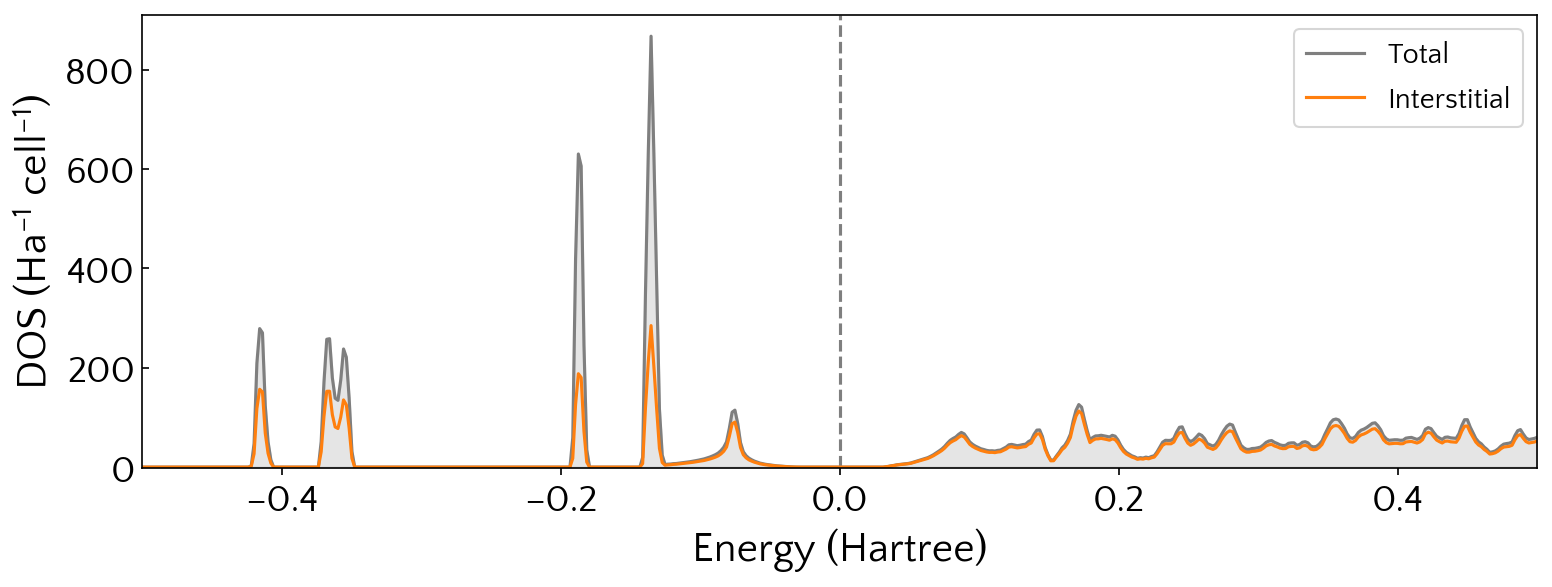

In [166]:
TDOS = get_total_dos(dos)
IDOS = get_interstitial_dos(dos)

min_e = min(min(TDOS[0]),min(IDOS[0]))
max_e = max(max(TDOS[0]),max(IDOS[0]))
efermi = 0.0 #Fermi energy

fig = plt.figure(dpi=150, figsize=(12,4))
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(TDOS[0], TDOS[1], color = 'C7', label = 'Total')
ax2.fill_between(TDOS[0], TDOS[1], alpha=0.2, color = 'C7')
ax2.plot(IDOS[0], IDOS[1], color = 'C1', label='Interstitial')

min_y,max_y = ax2.get_ylim()
ax2.vlines(efermi,0.0,max_y, color='k', alpha = 0.5, linestyle = '--')

ax2.tick_params(axis = 'y', direction = 'in')
ax2.set_ylabel(y_label+' (Ha$^{-1}$ cell$^{-1}$)')
ax2.set_xlabel(f'{x_label} ({x_unit})')
ax2.set_xlim(min_e, max_e)
ax2.set_ylim(-1,max_y)
ax2.legend(fontsize=14)
#plt.setp(ax2.get_yticklabels(), visible=False)
plt.show()

__Plot partial DOS (separated by atom and angular moment)__

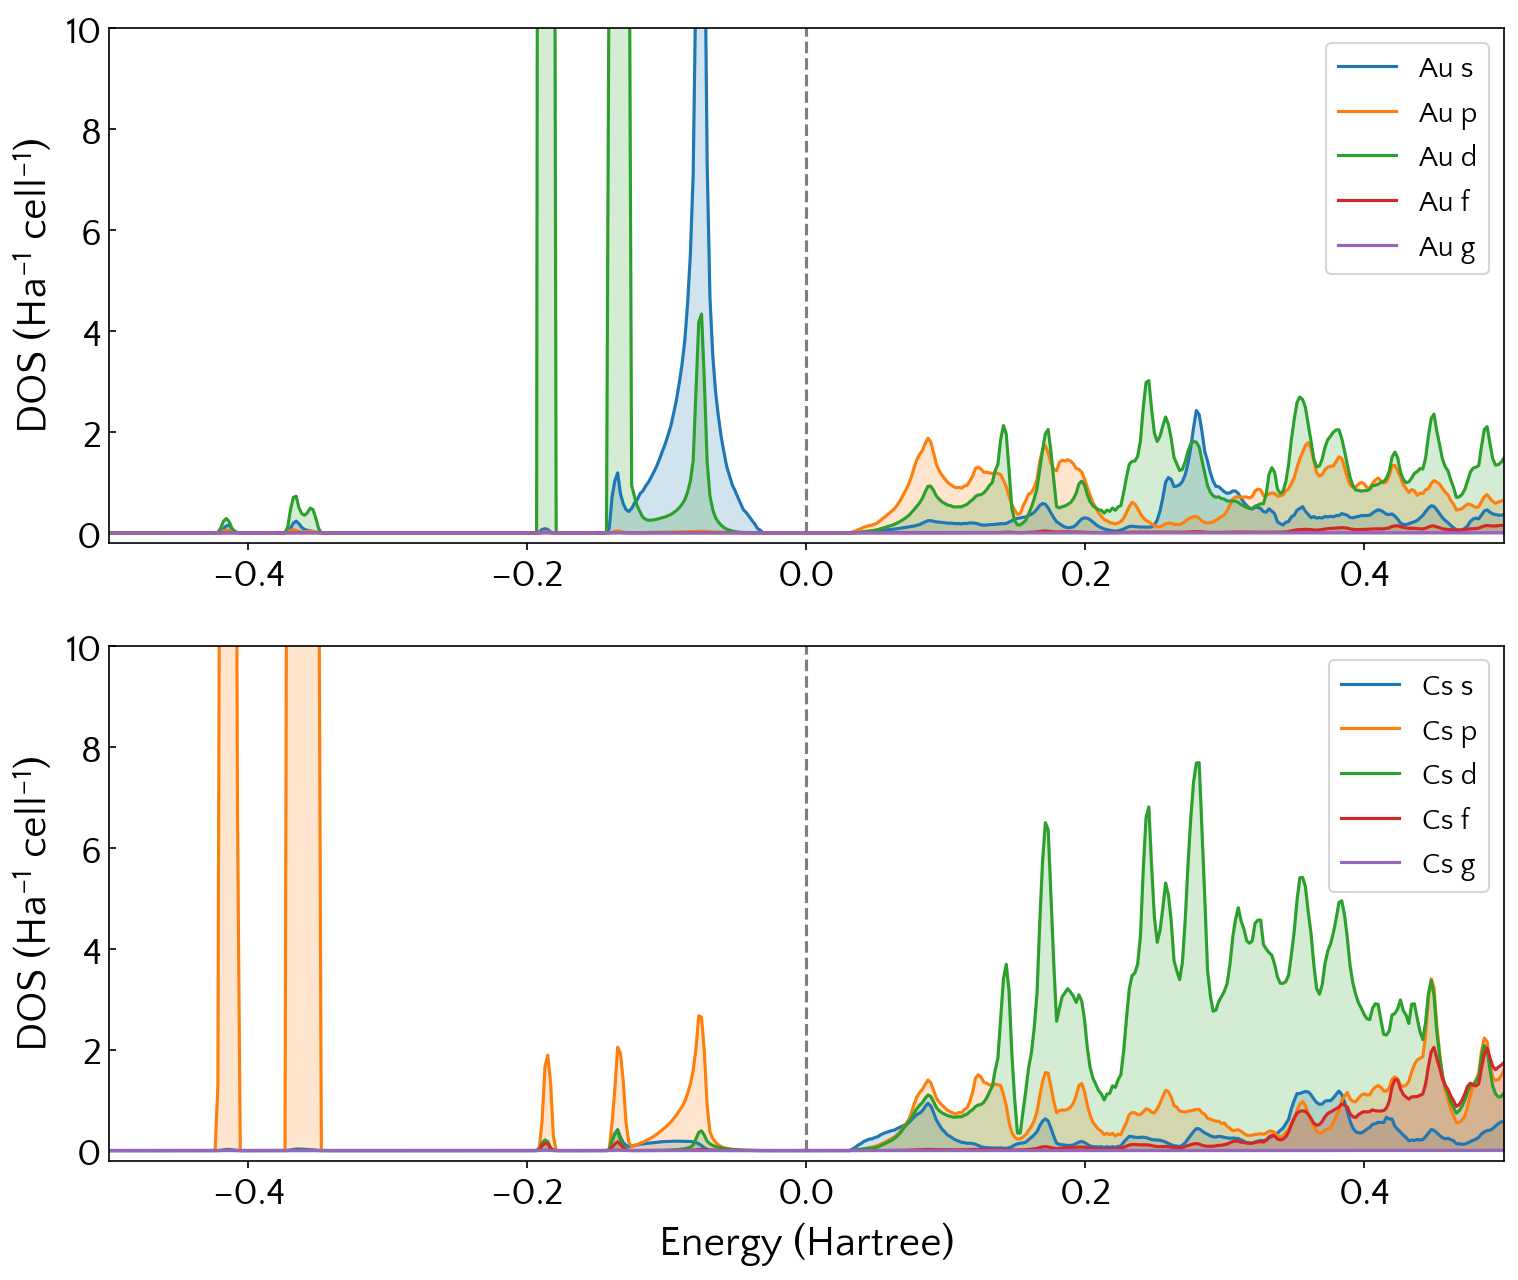

In [210]:
PDOS = get_partial_dos(dos)

colors_cs = ['C0','C1','C2','C3','C4','C5']
colors_au = ['C0','C1','C2','C3','C4','C5']
labels = ['s','p','d','f','g']

dos_cs = [PDOS['Cs'][1][l][1][1] for l in PDOS['Cs'][1].keys()]
dos_au = [PDOS['Au'][1][l][1][1] for l in PDOS['Cs'][1].keys()]
energy = PDOS['Au'][1][0][1][0]

min_e = min(energy)
max_e = max(energy)
efermi = 0.0 #Fermi energy

fig = plt.figure(dpi=150, figsize=(12,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

#plotting
for i in range(len(dos_cs)):
    ax1.plot(energy, dos_au[i], color = colors_au[i], label = 'Au '+labels[i])
    ax1.fill_between(energy, dos_au[i], alpha=0.2, color = colors_au[i])
    
    ax2.plot(energy, dos_cs[i], color = colors_cs[i], label = 'Cs '+labels[i])
    ax2.fill_between(energy, dos_cs[i], alpha=0.2, color = colors_cs[i])

#configuring
min_y,max_y = ax1.get_ylim()
ax1.vlines(efermi,0.0,max_y, color='k', alpha = 0.5, linestyle = '--')
ax1.tick_params(axis = 'y', direction = 'in')
ax1.set_ylabel(y_label+' (Ha$^{-1}$ cell$^{-1}$)')
ax1.set_xlim(min_e, max_e)
ax1.set_ylim(-1,max_y)
ax1.set_ylim(-0.2,10)
ax1.legend(fontsize=14)

min_y,max_y = ax2.get_ylim()
ax2.vlines(efermi,0.0,max_y, color='k', alpha = 0.5, linestyle = '--')
ax2.tick_params(axis = 'y', direction = 'in')
ax2.set_ylabel(y_label+' (Ha$^{-1}$ cell$^{-1}$)')
ax2.set_xlabel(f'{x_label} ({x_unit})')
ax2.set_xlim(min_e, max_e)
#ax2.set_ylim(-0.2,max_y)
ax2.set_ylim(-0.2,10)
ax2.legend(fontsize=14,ncol=1)
plt.show()